In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [4]:
chairs_dataset = raft_datasets.FlyingChairs(
    root='../datasets/FlyingChairs_release/data',
    split='validation', 
    split_file='../chairs_split.txt')
print(len(chairs_dataset))
img1, img2, flow, valid = chairs_dataset[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


640


In [78]:
from bootraft import BootRaft
args = set_args()
net = torch.nn.DataParallel(RAFT(args))
# net = torch.nn.DataParallel(BootRaft(args))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
ls ../checkpoints/*amax*

../checkpoints/10000_raft-tdw-bn-amaxflowframes.pth
../checkpoints/5000_raft-tdw-bn-amaxflowframes.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
load_path = '../checkpoints/10000_raft-tdw-bn-amaxflowframes.pth'
# load_path = '../models/raft-sintel.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [172]:
net.cuda()
net.eval()
net.module.freeze_bn()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(32)],
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24]):
    dataset.is_test = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    img1, img2, gt, _ = dataset[ex]
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        pred = flow_viz.flow_to_image(tensor_to_arr(pred))
        preds.append(pred)
    _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(1,2 + len(iters),figsize=(8 + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + ['gt']
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


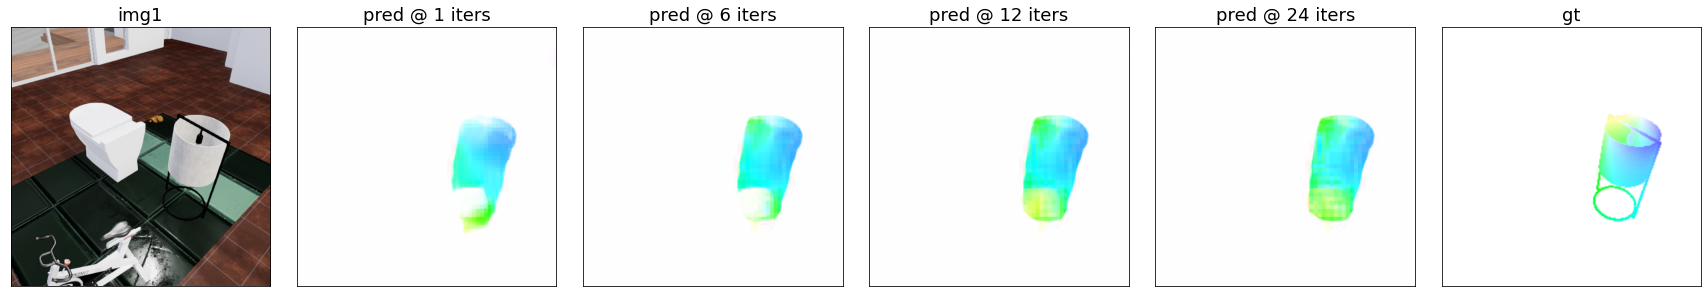

In [174]:
viz_raft_prediction(net, tdw_dataset, ex=41, iters=[1,6,12,24])

In [12]:
def normalize(img):
    return 2.0 * (img / 255.) - 1.0
img1, img2, flow, _ = tdw_dataset[1]
# fmap1, fmap2 = net.module.fnet([normalize(img1[None].cuda()), normalize(img2[None].cuda())])
# ctx = net.module.cnet(img1[None].cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
    img1, img2, flow = dataset[ex][:3]
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow))
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['image1', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['gt'])
        ax[2].imshow(return_vals['pred'])
        ax[3].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:3] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 3:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, return_errormap=False)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
print(load_path)

../checkpoints/raft-tdw-bn.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


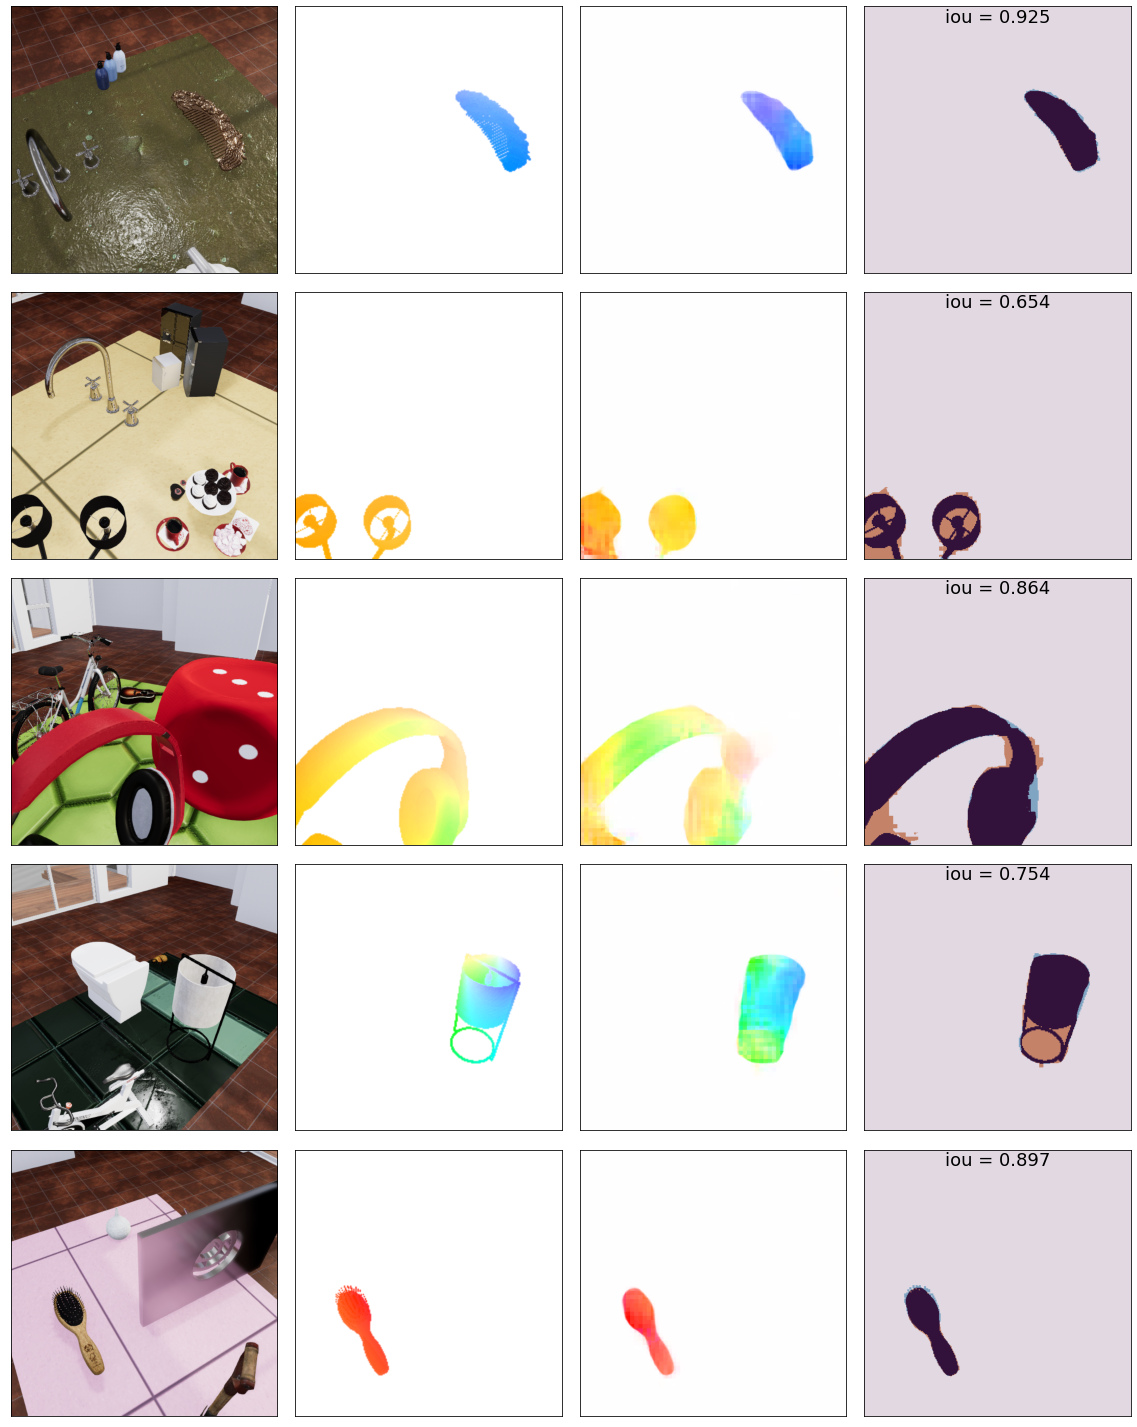

In [178]:
tdw_dataset.is_test = False
tdw_dataset.max_start_frame = 5
visualize_error_maps(net, tdw_dataset, examples=[1,3,11,41,80], thresh=4)

In [157]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/70000_raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<01:52,  3.95it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.7619782173872193,
  'precision': 0.8304135869596027,
  'recall': 0.8995004523456317},
 {'iou_isnan': 0.046, 'precision_isnan': 0.07, 'recall_isnan': 0.048})

In [158]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/70000_raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<02:02,  3.63it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.6091705282126694,
  'precision': 0.8581575683386515,
  'recall': 0.6961145410180197},
 {'iou_isnan': 0.028, 'precision_isnan': 0.18, 'recall_isnan': 0.03})

In [150]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/70000_raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<02:05,  3.52it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.6170019497860351,
  'precision': 0.8597757728016577,
  'recall': 0.7042583867172129},
 {'iou_isnan': 0.03, 'precision_isnan': 0.186, 'recall_isnan': 0.03})

In [153]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.50it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


({'iou': 0.8258794803290415,
  'precision': 0.9140077864749222,
  'recall': 0.8990444173111047},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [154]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:16,  3.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5279725941740948,
  'precision': 0.9000479561979515,
  'recall': 0.5769562252348509},
 {'iou_isnan': 0.03, 'precision_isnan': 0.308, 'recall_isnan': 0.032})

In [161]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:10,  3.38it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.7969608048584764,
  'precision': 0.9451550029757846,
  'recall': 0.8369056144481988},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [162]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


({'iou': 0.5751281585458882,
  'precision': 0.9517182482523737,
  'recall': 0.5998352226939102},
 {'iou_isnan': 0.026, 'precision_isnan': 0.214, 'recall_isnan': 0.028})

In [168]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/135000_raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:15<01:50,  4.01it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.8250745329952744,
  'precision': 0.9126674123845545,
  'recall': 0.899859982067258},
 {'iou_isnan': 0.042, 'precision_isnan': 0.084, 'recall_isnan': 0.048})

In [169]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/135000_raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:15<02:04,  3.55it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.5716569099648304,
  'precision': 0.9190602953628484,
  'recall': 0.6162700945691229},
 {'iou_isnan': 0.024, 'precision_isnan': 0.282, 'recall_isnan': 0.03})

In [175]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/10000_raft-tdw-bn-amaxflowframes.pth


 11%|█▏        | 57/500 [00:15<02:11,  3.36it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5987805408912165,
  'precision': 0.7164877515995296,
  'recall': 0.7937487803507045},
 {'iou_isnan': 0.032, 'precision_isnan': 0.08, 'recall_isnan': 0.048})

In [176]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/10000_raft-tdw-bn-amaxflowframes.pth


 11%|█▏        | 57/500 [00:15<02:01,  3.63it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


({'iou': 0.36834735242314,
  'precision': 0.6468569567302193,
  'recall': 0.46220698636431484},
 {'iou_isnan': 0.018, 'precision_isnan': 0.25, 'recall_isnan': 0.032})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


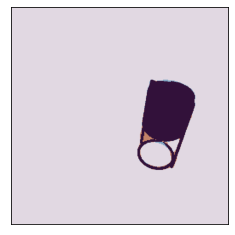

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


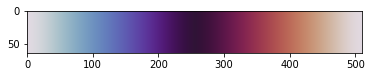

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
